In [1]:
## Preliminaries ##

# Import libraries
import pylab
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
%matplotlib inline

# Define to_image function
pixels = ["pixel_{0}".format(i) for i in range(400)] # 20*20 = 400
def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,20,20), axis=-1)

Using TensorFlow backend.


In [2]:
## Import the data ##

# List file names
# If you want the notebook to run out of the box, keep these names the same and change the pre-path on line 14
datafilenames = ["SharedHits/NormalizedCharge/output_final.h5","SharedHits/AbsoluteCharge/output_final.h5",
                "Shared100NonShared/NormalizedCharge/output_final.h5","Shared100NonShared/AbsoluteCharge/output_final.h5",
                "AllHits/NormalizedCharge/output_final.h5","AllHits/AbsoluteCharge/output_final.h5"]

# Select file you want to use
filenumber = 5
datafilename = datafilenames[filenumber]

# Import data
df = pd.read_hdf("/uscms_data/d3/bbonham/TrackerProject/TrackingDstar/LambaAnalyzer/output_of_postprocess/"+datafilename, 
                 key="df", mode='r')

# Print dataframe info
print '\033[1m' + datafilename[:-16] + '\033[0m' # name printed in bold
print df.info()

# Signal Region if you choose a file with only shared hits
if filenumber == 0 or filenumber == 1:
    signalstring = "['nUniqueSimTracksInSharedHit']>1"
# Signal Region if you choose a file with shared and nonshared hits
if filenumber in [2,3,4,5]:
    #signalstring = "['isSharedHit']==1"
    signalstring = "['nUniqueSimTracksInSharedHit']>1"

AllHits/AbsoluteCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 411064 entries, 0 to 411063
Columns: 407 entries, pixel_78 to pixel_148
dtypes: float64(405), int32(1), int64(1)
memory usage: 1.2 GB
None


In [3]:
## CNN ##
# Adding layers to Neural Network: (1) is convolutional,(1.5) 2D layer ,(2) flatten output then feed it to (3) which is a regular neural network.
# (4) drops nodes in NN to avoid overfitting, finallly (5) outputs 2 values (prob(notmergedhit), prob(merged hit)), must add up to 1.

# Define the network
model = keras.models.Sequential()

#layer (1) you can play with these layers individually or together until you find the best combination
model.add(keras.layers.Conv2D(32, kernel_size=(8,8), padding='same', activation='relu', input_shape=(20,20,1), data_format = "channels_last"))
model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu')) 
#model.add(keras.layers.Conv2D(16, kernel_size=(2,2), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(1,1), padding='same', activation='relu'))

# layer (X): max pooling 2D, has always been commented out, but you can uncomment it and see what it does
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format="channels_last"))

# layer (2)
model.add(keras.layers.Flatten(input_shape=(20,20,1))) # 20,20

# layer 2.5, dropout 10%
model.add(Dropout(0.1))

# layer (3)
model.add(keras.layers.Dense(100, activation='relu'))

#layer (4)
model.add(keras.layers.Dense(2, activation='softmax'))
                                                    
# Layer (5), train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"]) 

# Number of times you run the CNN
epochs_number = 100 

# Stop training early to prevent overtraining
early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

In [4]:
## Set the train-test split ##

# Must be the same integer as when you trained the model. Always 10 for me. 
# Alternatively, you could save df_train and load it, but I chose to do it with a consistent seed instead. 
train_test_seed = 10 
df_train,df_test = train_test_split(df,test_size=0.5,random_state=train_test_seed)
images_train = to_image(df_train)
images_test = to_image(df_test)

# Sanity check: Printout (events, variables). Variables include 400 pixels, and a few others you can find using df.info()
print "Test Data Shape: ",df_test.shape
print "Train Data Shape: ",df_train.shape

Test Data Shape:  (205532, 407)
Train Data Shape:  (205532, 407)


In [5]:
### Train classifier ###

# Checkpoint model architecture + parameters
model_checkpoint_name = 'TrainedModel_'+datafilename[:-16].replace('/','_')+'.h5'
model_checkpoint = ModelCheckpoint(model_checkpoint_name, monitor='val_loss', save_best_only=True, 
                                   save_weights_only=False, mode='auto', period=1)
# Fit model
history = model.fit(images_train,
                    keras.utils.to_categorical( eval("df_train"+signalstring) ), 
                    epochs = epochs_number, 
                    callbacks = [early_stopping, model_checkpoint], 
                    validation_split = 0.1) # fraction of training sample used for testing (here 10%)
# Save model (again)
model.save(model_checkpoint_name)
print "\nSaved:",model_checkpoint_name

Train on 184978 samples, validate on 20554 samples
Epoch 1/100
184978/184978 [==============================] - 659s 4ms/step - loss: 0.1136 - acc: 0.9619 - val_loss: 0.1027 - val_acc: 0.9648
Epoch 2/100
184978/184978 [==============================] - 391s 2ms/step - loss: 0.0976 - acc: 0.9657 - val_loss: 0.0956 - val_acc: 0.9658
Epoch 3/100
184978/184978 [==============================] - 333s 2ms/step - loss: 0.0918 - acc: 0.9675 - val_loss: 0.0892 - val_acc: 0.9682
Epoch 4/100
184978/184978 [==============================] - 333s 2ms/step - loss: 0.0874 - acc: 0.9693 - val_loss: 0.0864 - val_acc: 0.9677
Epoch 5/100
184978/184978 [==============================] - 337s 2ms/step - loss: 0.0839 - acc: 0.9708 - val_loss: 0.0844 - val_acc: 0.9683
Epoch 6/100
184978/184978 [==============================] - 336s 2ms/step - loss: 0.0809 - acc: 0.9720 - val_loss: 0.0828 - val_acc: 0.9695
Epoch 7/100
184978/184978 [==============================] - 333s 2ms/step - loss: 0.0785 - acc: 0.9731

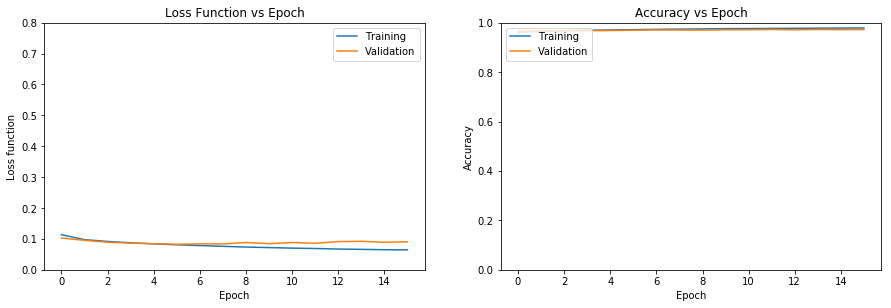

In [6]:
## loss vs epoch and acc vs epoch plots ##

# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label='Validation')
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss function')
ax.set_title("Loss Function vs Epoch")
pylab.ylim([0,0.8])

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='Training')
ax.plot(history.history['val_acc'], label='Validation')
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy vs Epoch")
pylab.ylim([0,1])

plt.plot();

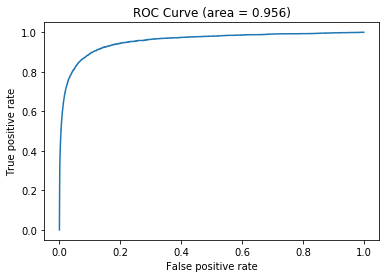

In [7]:
## ROC curve ##

ret = model.predict(images_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical( eval("df_test"+signalstring) )[:,1], ret[:,1])
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc = np.trapz(tpr_keras,fpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve (area = {:.3f})'.format(auc))
plt.show()